<a href="https://colab.research.google.com/github/SChaeck/papers2code/blob/main/Transformer_KoreanEnglish_translator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Attention Is All You Need: Transformer**
* 참고:
  * 동빈나 (https://colab.research.google.com/github/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/code_practices/Attention_is_All_You_Need_Tutorial_(German_English).ipynb)
  * Qscar (https://github.com/leadbreak/study/blob/main/algorithm/02.transformer_intermediate/02.transformer_intermediate.ipynb)


# * Prework

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

!pip install transformers
!pip install sentencepiece # MarinTokenizer
!pip install sacremoses # MarinMTModel 에서 불러올 때 waring 방지
!pip install -U kaleido

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (31.6 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121749 files and direc

In [3]:
import kaleido
print(kaleido.__version__)

0.2.1


# * Load Data & Preview

In [4]:
import pandas as pd
import torch

In [5]:
# 데이터는 AIHub에서 다운로드함.
data = pd.read_excel('/content/drive/MyDrive/AI/Study/AIHub_Data/한국어-영어 번역(병렬) 말뭉치/2_대화체.xlsx')
data.head()

,대분류,소분류,상황,Set Nr.,발화자,원문,번역문
0,비즈니스,회의,의견 교환하기,1,A-1,이번 신제품 출시에 대한 시장의 반응은 어떤가요?,How is the market's reaction to the newly rele...
1,비즈니스,회의,의견 교환하기,1,B-1,판매량이 지난번 제품보다 빠르게 늘고 있습니다.,The sales increase is faster than the previous...
2,비즈니스,회의,의견 교환하기,1,A-2,그렇다면 공장에 연락해서 주문량을 더 늘려야겠네요.,"Then, we'll have to call the manufacturer and ..."
3,비즈니스,회의,의견 교환하기,1,B-2,"네, 제가 연락해서 주문량을 2배로 늘리겠습니다.","Sure, I'll make a call and double the volume o..."
4,비즈니스,회의,의견 교환하기,2,A-1,지난 회의 마지막에 논의했던 안건을 다시 볼까요?,Shall we take a look at the issues we discusse...


In [6]:
BATCH_SIZE = 32 # 논문은 2.5만 token
EPOCH = 9 # 논문은 약 560 에포크
max_len = 512
d_model = 512

warmup_steps = int(95_104/BATCH_SIZE*EPOCH*0.04) # 논문은 4,000 스텝
LR_scale = 1 # Noam scheduler에 peak LR 값 조절을 위해 곱해짐

warmup_steps

1069

In [7]:
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, data):
    self.data = data

  def __len__(self):
    return self.data.shape[0]

  def __getitem__(self, idx):
    return self.data.loc[idx, '원문'], self.data.loc[idx, '번역문']

data = pd.read_excel('/content/drive/MyDrive/AI/Study/AIHub_Data/한국어-영어 번역(병렬) 말뭉치/2_대화체.xlsx')
custom_DS = CustomDataset(data)

train_DS, val_DS, test_DS = torch.utils.data.random_split(custom_DS, [95104, 3896, 1000])

train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
val_DL = torch.utils.data.DataLoader(val_DS, batch_size=BATCH_SIZE, shuffle=True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)

print(len(train_DS))
print(len(val_DS))
print(len(test_DS))

95104
3896
1000


# 1. Import Libraries

In [8]:
import time
import torch
from torch import nn, optim
import torch.nn.functional as F
from transformers import MarianMTModel, MarianTokenizer
import pandas as pd
from tqdm import tqdm
import math
import matplotlib.pyplot as plt

import plotly.graph_objs as go

In [9]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# 2. Load Tokenizer

In [10]:
# Load tokenizer
tokenizer = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-ko-en')

eos_idx = tokenizer.eos_token_id # 문장 끝 토큰 인덱스
pad_idx = tokenizer.pad_token_id # 패딩 토근 인덱스
print("eos_idx = ", eos_idx)
print("pad_idx = ", pad_idx)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/842k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/813k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

eos_idx =  0
pad_idx =  65000


In [11]:
vocab_size = tokenizer.vocab_size
print(f'tokenizer의 사전 크기: {vocab_size}')

tokenizer의 사전 크기: 65001


In [12]:
text = 'Tokenizer Test is Started with HuggingFace MarianTokenizer'
print(f'original: {text}')
print(f'token: {tokenizer.tokenize(text)}')

original: Tokenizer Test is Started with HuggingFace MarianTokenizer
token: ['▁', 'To', 'k', 'en', 'iz', 'er', '▁T', 'est', '▁is', '▁St', 'art', 'ed', '▁with', '▁H', 'ug', 'g', 'ing', 'F', 'ace', '▁Mar', 'ian', 'To', 'k', 'en', 'iz', 'er']


In [13]:
text = '허깅페이스 마리안 토크나이저로 수행하는 토크나이저 테스트'
print(f'original: {text}')
print(f'token: {tokenizer.tokenize(text)}')

original: 허깅페이스 마리안 토크나이저로 수행하는 토크나이저 테스트
token: ['▁허', '깅', '페이스', '▁마리', '안', '▁토', '크', '나이', '저', '로', '▁수', '행하는', '▁토', '크', '나이', '저', '▁테스트']


In [14]:

text = '문장을 넣으면 토크나이즈해서 숫자로 바꿔줍니다.'

tokenized = tokenizer.tokenize(text)
encoded_tokens = tokenizer.encode(text, add_special_tokens=False)
encoded_tokens_end = tokenizer.encode(text, add_special_tokens=True)

print(tokenized)
print(encoded_tokens)
print(encoded_tokens_end)

['▁문장', '을', '▁넣으면', '▁토', '크', '나이', '즈', '해서', '▁숫자', '로', '▁바꿔', '줍니다', '.']
[13774, 51, 40068, 4155, 1020, 5037, 1329, 969, 6635, 131, 8104, 6839, 2]
[13774, 51, 40068, 4155, 1020, 5037, 1329, 969, 6635, 131, 8104, 6839, 2, 0]


In [15]:
print(tokenizer.decode([0]))
print(tokenizer.decode([13774]))
tokenizer.decode(encoded_tokens)

</s>
문장


'문장을 넣으면 토크나이즈해서 숫자로 바꿔줍니다.'

# 3. Scheduler & Optimizer

## Noam Scheduler 공식

### $\text{Learning Rate} = \frac{1}{\sqrt{d_{\text{model}}}} \times \min\left(\frac{1}{\sqrt{\text{step\_num}}}, \frac{\text{step\_num}}{\text{warmup\_steps}^{1.5}}\right)$

In [16]:
def count_params(model):
  num = sum([p.numel() for p in model.parameters() if p.requires_grad])
  return num

class NoamScheduler:
  def __init__(self, optimizer, d_model, warmup_steps, LR_scale=1):
    self.optimizer = optimizer # 최적화할 옵티마이저
    self.step_count = 0 # 현재까지 진행된 스텝 수 (이 값이 warmup_steps보다 작으면 웜엄 단계임)
    self.d_model = d_model # 모델의 차원 수
    self.warmup_steps = warmup_steps # 웜업 단계에서의 스텝 수
    self.LR_scale = LR_scale # 학습률 스케일 인자 -> 학습률을 스케일링 하는 역할
    self._d_model_factor = self.LR_scale * (self.d_model ** -0.5) # 모델 차원에 대한 계수를 미리 계산

  def step(self):
    self.step_count += 1 # 스텝 수 증가
    lr = self.calculate_learning_rate() # 새 학습률 계산
    self.optimizer.param_groups[0]['lr'] = lr # 옵티마이저의 학습률 갱신

  def calculate_learning_rate(self):
    # 웜업에서는 학습률을 서서히 증가시키고, 이후에는 감소
    minimum_factor = min(self.step_count ** -0.5, self.step_count * self.warmup_steps ** -1.5)
    return self._d_model_factor * minimum_factor

def plot_scheduler(scheduler_name, optimizer, scheduler, total_steps): # LR curve 보는 함수
  lr_history = []
  steps = range(1, total_steps)

  for _ in steps: # base model -> 10만 steps (12시간), big model -> 30만 steps (3.5일) 로 훈련했었음
    lr_history += [optimizer.param_groups[0]['lr']]
    scheduler.step()

  plt.figure()
  if total_steps == 100000:
      plt.plot(steps, (512 ** -0.5) * torch.tensor(steps) ** -0.5, 'g--', linewidth=1, label=r"$d_{\mathrm{model}}^{-0.5} \cdot \mathrm{step}^{-0.5}$")
      plt.plot(steps, (512 ** -0.5) * torch.tensor(steps) * 4000 ** -1.5, 'r--', linewidth=1, label=r"$d_{\mathrm{model}}^{-0.5} \cdot \mathrm{step} \cdot \mathrm{warmup\_steps}^{-1.5}$")
  plt.plot(steps, lr_history, 'b', linewidth=2, alpha=0.35, label="Learning Rate")

  plt.ylim([-0.1*max(lr_history), 1.2*max(lr_history)])
  plt.xlabel('Step')
  plt.ylabel('Learning Rate')
  plt.grid()
  plt.legend()
  plt.show()

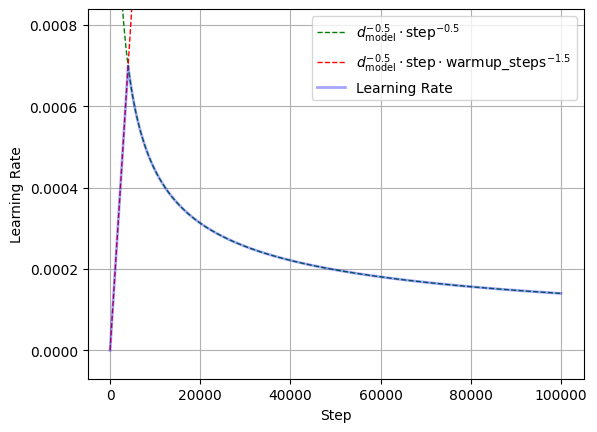

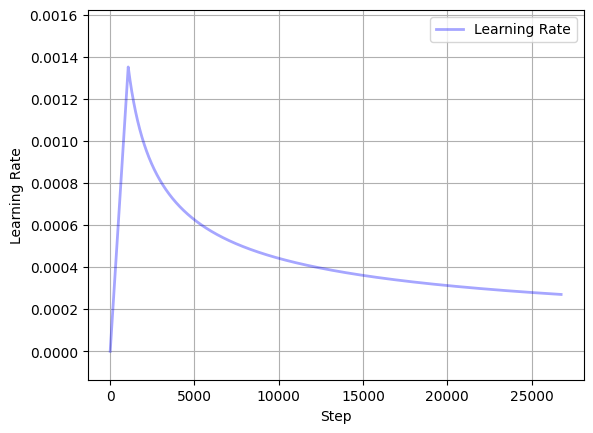

In [17]:
optimizer = optim.Adam(nn.Linear(1, 1).parameters(), lr=0) # 테스트용 optimizer
scheduler = NoamScheduler(optimizer, d_model=512, warmup_steps=4000)
plot_scheduler(scheduler_name='Noam', optimizer=optimizer, scheduler=scheduler, total_steps=100000)

optimizer = optim.Adam(nn.Linear(1, 1).parameters(), lr=0)
scheduler = NoamScheduler(optimizer, d_model=d_model, warmup_steps=warmup_steps, LR_scale=LR_scale)
plot_scheduler(scheduler_name='Noam', optimizer=optimizer, scheduler=scheduler, total_steps=int(len(train_DS)*EPOCH/BATCH_SIZE))

# 4. Regularization - Label Smoothing Loss
* Hard target을 소프트하게 변형 -> 과적합 방지
* 간략하게 이해만 했음. 추가 공부 필요


In [18]:
###추가공부 필요###
def smooth_label(targets: torch.Tensor, classes: int, smoothing=0.1):
  assert 0 <= smoothing < 1
  confidence = 1.0 - smoothing # confidence: 원래 라벨에 할당될 확률값
  label_shape = torch.Size((targets.size(0), classes)) # 스무딩 된 라벨 형태

  with torch.no_grad(): # 라벨 스무딩은 학습에 영향을 주는 것이 아니므로 그래디언트 계산에 포함되지 않도록 함
    smooth_labels = torch.empty(size=label_shape, device=targets.device)
    smooth_labels.fill_(smoothing / (classes - 1))
    smooth_labels.scatter_(1, targets.data.unsqueeze(1), confidence)
  return smooth_labels

def custom_cross_entropy(input, target, smoothing=0.1, ignore_index=-100):
  log_probs = F.log_softmax(input, dim=-1)
  target = smooth_label(target, input.size(-1), smoothing)

  if ignore_index >= 0:
    mask = target != ignore_index
    target = target[mask]
    log_probs = log_probs[mask]

  loss = (-target * log_probs).sum(dim=-1)
  return loss.mean()

In [19]:
input = torch.randn(3, 5, requires_grad=True) # 임의의 예측값
target = torch.tensor([1, 0, 4]) # 실제 레이블
label = smooth_label(target, input.size(-1), 0.0)
label_smoothing = smooth_label(target, input.size(-1), 0.1)

loss = custom_cross_entropy(input, target, smoothing=0.0, ignore_index=pad_idx)
loss_smoothing = custom_cross_entropy(input, target, smoothing=0.1, ignore_index=pad_idx)
input, label, label_smoothing, loss, loss_smoothing

(tensor([[ 1.0210,  0.3592,  0.9218,  1.8279, -0.4869],
         [-1.0743,  1.4949,  1.3016, -0.9746,  0.3319],
         [-0.5569,  0.6930,  1.6188,  0.0658,  0.0155]], requires_grad=True),
 tensor([[0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1.]]),
 tensor([[0.0250, 0.9000, 0.0250, 0.0250, 0.0250],
         [0.9000, 0.0250, 0.0250, 0.0250, 0.0250],
         [0.0250, 0.0250, 0.0250, 0.0250, 0.9000]]),
 tensor(7.9060, grad_fn=<MeanBackward0>),
 tensor(7.6546, grad_fn=<MeanBackward0>))

In [20]:
class LabelSmoothingCrossEntropyLoss(nn.Module):
  def __init__(self, smoothing=0.1, ignore_index=65000):
    super(LabelSmoothingCrossEntropyLoss, self).__init__()
    self.smooting = smoothing # 스무딩 파라미터: 0에 가까울 수록 일반 CE와 값이 같아짐
    self.ignore_index = ignore_index # 무시할 레이블(패딩)의 인덱스. -> loss 계산에서 제외됨

  def forward(self, input, target):
    log_probs = F.log_softmax(input, dim=-1) # 입력 텍스트에 대한 로그 소프트맥스를 적용하여 모델의 예측 로그 확률 계산
    n_classes = input.size(-1) # 출력 언어의 어휘 크기를 계산 - 일반적인 분류 문제에서는 클래스의 수

    with torch.no_grad():
      true_dist = torch.full_like(log_probs, self.smoothing / (n_classes - 1)) # 스무딩된 레이블 분포를 생성. 각 클래스(어휘)에 작은 확률을 할당해 다양한 번역을 고려하도록
      ignore = target == self.ignore_index # 무시할 레이블을 처리합니다. -> 패딩 토큰
      target = target.masked_fill(ignore, 0) # 무시할 레이블을 0으로 설정
      true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.smoothing) # 실제 레이블 위치에 (1 - 스무딩) 값을 할당
      true_dist.masked_fill_(ignore.unsqueeze(1), 0) # 무시할 레이블의 위치에 0을 할당

      mask = ~ignore # 무시할 인덱스에 대한 마스크를 생성

    loss = -true_dist * log_probs # 손실을 계산합니다. 마스크를 적용하여 무시할 인덱스를 제외
    loss = loss.masked_select(mask.unsqueeze(1)).mean() # 최종 손실을 평균내어 반환

    return loss


In [21]:
# Case 1: Label Smoothing + CE Loss
criterion = LabelSmoothingCrossEntropyLoss(smoothing=0.1, ignore_index=pad_idx)
# Case 2: CE Loss only
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

In [22]:
# Case 1: Label Smoothing + CE Loss
criterion = nn.CrossEntropyLoss(label_smoothing=0.1, ignore_index=pad_idx)
# Case 2: CE Loss only
criterion = nn.CrossEntropyLoss(label_smoothing=0.0,ignore_index=pad_idx)

In [23]:
# paper
criterion = nn.CrossEntropyLoss(label_smoothing=0.1,ignore_index=pad_idx)

#### **Multi Head Attention 아키텍처**

* 어텐션(attention)은 <b>세 가지 요소</b>를 입력으로 받습니다.
    * <b>쿼리(queries)</b>
    * <b>키(keys)</b>
    * <b>값(values)</b>
    * 현재 구현에서는 Query, Key, Value의 차원이 모두 같습니다.
* 하이퍼 파라미터(hyperparameter)
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **n_heads**: 헤드(head)의 개수 = scaled dot-product attention의 개수
    * **dropout_ratio**: 드롭아웃(dropout) 비율

In [24]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, dropout_ratio, device):
        super().__init__()

        assert hidden_dim % n_heads == 0

        self.hidden_dim = hidden_dim
        self.n_heads = n_heads
        self.head_dim = hidden_dim // n_heads

        self.fc_q = nn.Linear(hidden_dim, hidden_dim)
        self.fc_k = nn.Linear(hidden_dim, hidden_dim)
        self.fc_v = nn.Linear(hidden_dim, hidden_dim)

        self.fc_o = nn.Linear(hidden_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):
        batch_size = query.shape[0]

        # query, key, value: [batch_size, *_len, hidden_dim]

        # FC 레이어를 거치면서 query, key, value가 특징을 더 잘 표현하게 됨.
        Q = self.fc_q(query).view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = self.fc_k(key).view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = self.fc_v(value).view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # query, key, value: [batch_size, n_heads, *_len, hidden_dim]

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        # energy: [batch_size, n_heads, query_len, key_len]

        if mask is not None:
            energy = energy.masked_fill(mask==0, -1e10)

        attention = torch.softmax(energy, dim=-1)

        # attention: [batch_size, n_heads, query_len, key_len]

        x = torch.matmul(self.dropout(attention), V)
        x = x.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.hidden_dim)
        x = self.fc_o(x)

        return x, attention

#### **Position-wise Feedforward 아키텍처**

* 입력과 출력의 차원이 동일합니다.
* 하이퍼 파라미터(hyperparameter)
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **pf_dim**: Feedforward 레이어에서의 내부 임베딩 차원
    * **dropout_ratio**: 드롭아웃(dropout) 비율

In [25]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hidden_dim, pf_dim, dropout_ratio):
        super().__init__()

        self.fc_1 = nn.Linear(hidden_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, x):
        x = self.dropout(torch.relu(self.fc_1(x)))
        x = self.fc_2(x)
        return x

### **인코더(Encoder) 레이어 아키텍처**

* 하나의 인코더 레이어에 대해 정의합니다.
    * 입력과 출력의 차원이 같습니다.
    * 이렇나 특징을 이용해 트랜스포머의 인코더는 인코더 레이어를 여러 번 중첩해 사용합니다.
* 하이퍼 파라미터(hyperparameter)
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **n_heads**: 헤드(head)의 개수 = scaled dot-product attention의 개수
    * **pf_dim**: Feedforward 레이어에서의 내부 임베딩 차원
    * **dropout_ratio**: 드롭아웃(dropout) 비율
* &lt;pad&gt; 토큰에 대하여 마스크(mask) 값을 0으로 설정합니다.

In [26]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)

        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, src, src_mask):
        # src: [batch_size, src_len, hidden_dim]
        # src_mask: [batch_size, src_len]

        _src, attn_enc = self.self_attention(src, src, src, src_mask)
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        _src = self.positionwise_feedforward(src)
        src = self.ff_layer_norm(src + self.dropout(_src))

        return src, attn_enc

### **인코더(Encoder) 아키텍처**

* 전체 인코더 아키텍처를 정의합니다.
* 하이퍼 파라미터(hyperparameter)
    * **input_dim**: 하나의 단어에 대한 원 핫 인코딩 차원
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **n_layers**: 내부적으로 사용할 인코더 레이어의 개수
    * **n_heads**: 헤드(head)의 개수 = scaled dot-product attention의 개수
    * **pf_dim**: Feedforward 레이어에서의 내부 임베딩 차원
    * **dropout_ratio**: 드롭아웃(dropout) 비율
    * **max_length**: 문장 내 최대 단어 개수
* 원본 논문과는 다르게 **위치 임베딩(positional embedding)을 학습**하는 형태로 구현합니다.
    * BERT와 같은 모던 트랜스포머 아키텍처에서 사용되는 방식입니다.
* &lt;pad&gt; 토큰에 대하여 마스크(mask) 값을 0으로 설정합니다.

In [27]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(input_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)

        self.layers = nn.ModuleList([EncoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, src, src_mask, attn_map_save=False):
        # src: [batch_size, src_len] -> src_len에는 단어를 나타내는 정수 인덱스가 저장됨
        # src_mask: [batch_size, src_len]

        batch_size = src.shape[0]
        src_len = src.shape[1]

        # torch.arange(0, 10) -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos: [batch_size, src_len]

        # 토큰 임베딩에 스케일을 진행하여 토큰 간의 차이를 더 명확히 하고, pos 임베딩 값에 비해 큰 비중을 둠
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

        # src: [batch_size, src_len, hidden_dim] <- 임베딩 레이어를 거쳤기 때문에 hidden_dim 차원이 생성됐다.

        attn_encs = []
        for layer in self.layers:
            src, attn_enc = layer(src, src_mask)
            if attn_map_save:
                attn_encs.append(attn_enc[0].unsqueeze(0))

        if attn_map_save:
            attn_encs = torch.cat(attn_encs, dim=0)

        return src, attn_encs

### Scale Effect of Input Embedding
* 추가 공부 필요

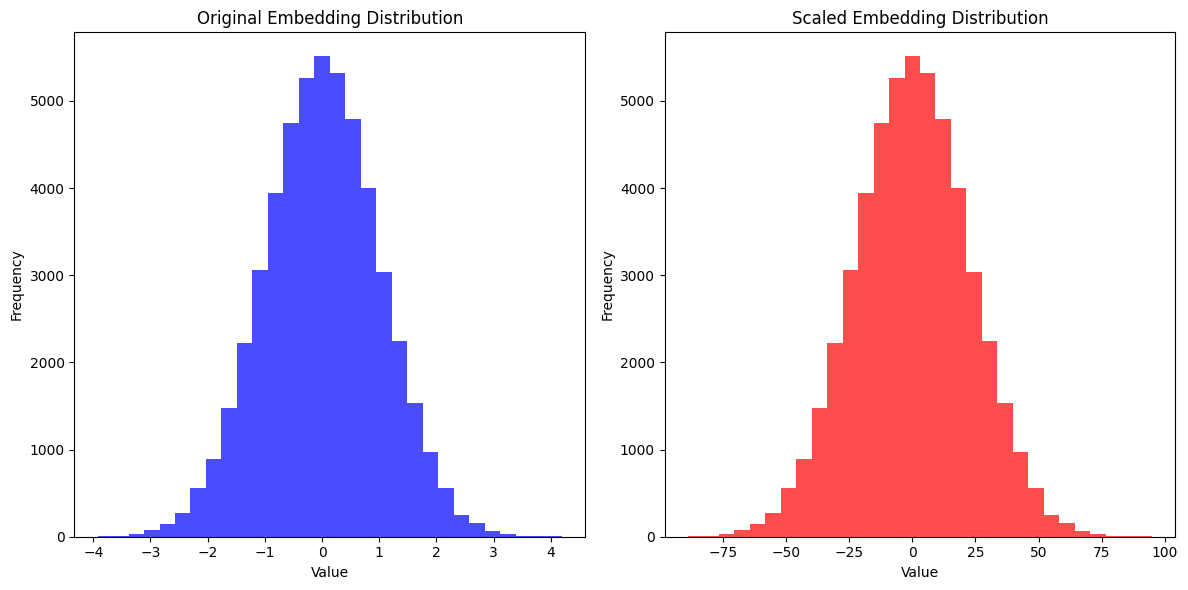

In [28]:
import torch
import matplotlib.pyplot as plt

# 임베딩 벡터와 d_model 설정
d_model = d_model
embedding_vector = torch.randn(100, d_model)

# 스케일링 팩터 적용
scale = torch.sqrt(torch.tensor(d_model, dtype=torch.float32))
scaled_embedding_vector = scale * embedding_vector

# 임베딩 벡터의 분포를 히스토그램으로 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(embedding_vector.numpy().flatten(), bins=30, color='blue', alpha=0.7)
plt.title("Original Embedding Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(scaled_embedding_vector.numpy().flatten(), bins=30, color='red', alpha=0.7)
plt.title("Scaled Embedding Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

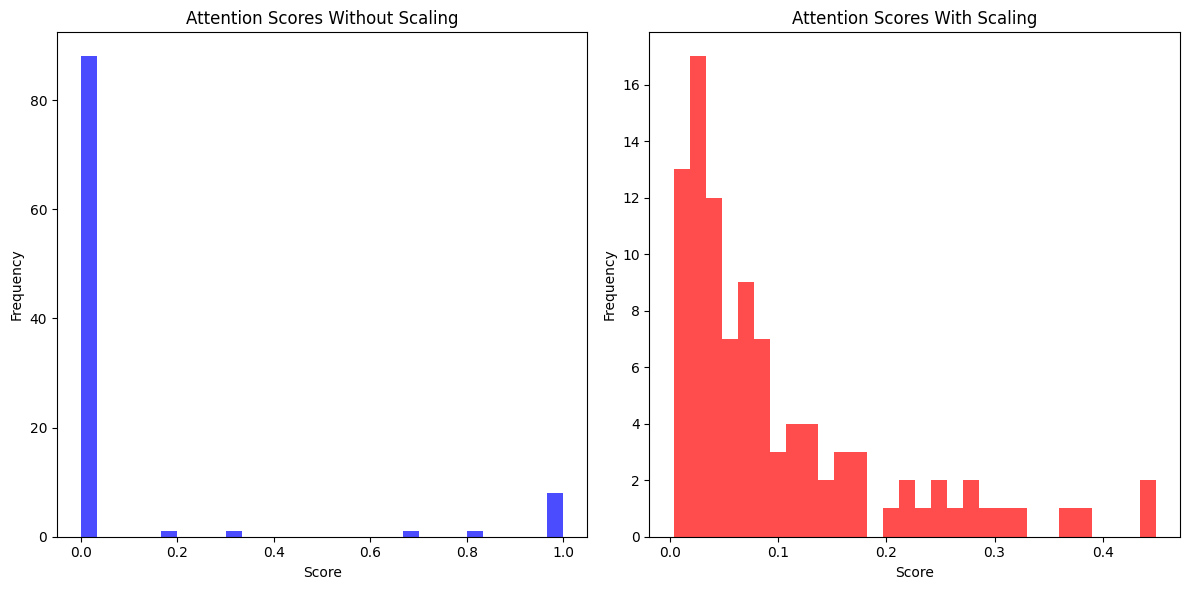

In [29]:
def attention(query, key, scale=None):
    """
    간단한 어텐션 메커니즘을 구현한 함수입니다.
    :param query: 쿼리 벡터
    :param key: 키 벡터
    :param scale: 스케일링 팩터
    :return: 어텐션 스코어
    """
    d_k = query.size(-1)

    # query와 key의 내적 계산
    scores = torch.matmul(query, key.transpose(-2, -1))

    if scale:
        scores = scores / scale

    return torch.softmax(scores, dim=-1)

# 임의의 쿼리, 키, 밸류 생성
query = torch.randn(10, d_model)
key = torch.randn(10, d_model)

# 스케일링 적용 전후의 어텐션 스코어 계산
attention_scores_without_scaling = attention(query, key)
attention_scores_with_scaling = attention(query, key, scale)

# 어텐션 스코어의 분포를 히스토그램으로 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(attention_scores_without_scaling.numpy().flatten(), bins=30, color='blue', alpha=0.7)
plt.title("Attention Scores Without Scaling")
plt.xlabel("Score")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(attention_scores_with_scaling.numpy().flatten(), bins=30, color='red', alpha=0.7)
plt.title("Attention Scores With Scaling")
plt.xlabel("Score")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

### **디코더(Decoder) 레이어 아키텍처** ###
* 하나의 디코더 레이어에 대해 정의합니다.
    * 입력과 출력의 차원이 같습니다.
    * 이러한 특징을 이용해 트랜스포머의 디코더는 디코더 레이어를 여러 번 중첩해 사용합니다.
    * 디코더 레이어에서는 두 개의 Multi-Head Attention 레이어가 사용됩니다.
* 하이퍼 파라미터(hyperparameter)
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **n_heads**: 헤드(head)의 개수 = scaled dot-product attention의 개수
    * **pf_dim**: Feedforward 레이어에서의 내부 임베딩 차원
    * **dropout_ratio**: 드롭아웃(dropout) 비율
* 소스 문장의 &lt;pad&gt;토큰에 대하여 마스크(mask) 값을 0으로 설정합니다.
* 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크를 사용합니다.

In [30]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.encoder_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        # trg: [batch_size, trg_len, hidden_dim]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_maks: [batch_size, src_len]

        # self attention
        _trg, attn_dec = self.self_attention(trg, trg, trg, trg_mask)
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        # encoder attention
        _trg, attn_enc_dec = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

        # positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        return trg, attn_dec, attn_enc_dec

### **디코더(Decoder) 아키텍처**
* 전체 디코더 아키텍처를 정의합니다.
* 하이퍼 파라미터(hyperparameter)
    * **output_dim**: 하나의 단어에 대한 원 핫 인코딩 차원
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **n_layers**: 내부적으로 사용할 디코더 레이어의 개수
    * **n_heads**: 헤드(head)의 개수 = scaled dot-product attention의 개수
    * **pf_dim**: Feedforward 레이어에서의 내부 임베딩 차원
    * **dropout_ratio**: 드롭아웃(dropout) 비율
    * **max_length**: 문장 내 최대 단어 개수
* 원본 논문과는 다르게 **위치 임베딩(positional embedding)을 학습**하는 형태로 구현합니다.
    * BERT와 같은 모던 트랜스포머 아키텍처에서 사용되는 방식입니다.
* Seq2Seq과는 마찬가지로 실제로 추론(inference) 시기에서는 디코더를 반복적으로 넣을 필요가 있습니다.
    * 학습(training) 시기에서는 한 번에 출력 문장을 구해 학습할 수 있습니다.
* 소스 문장의 &lt;pad&gt; 토큰에 대하여 마스크(mask) 값을 0으로 설정합니다.
* 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크를 사용합니다.

In [31]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(output_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)

        self.layers = nn.ModuleList([DecoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_ratio)
        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask, attn_map_save=False):
        # trg: [batch_size, trg_len]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))

        # pos: [batch_size, trg_len]
        # trg: [batch_size, trg_len, hidden_dim]

        attn_decs = []
        attn_enc_decs = []
        for layer in self.layers:
            trg, attn_dec, attn_enc_dec = layer(trg, enc_src, trg_mask, src_mask)
            if attn_map_save:
                attn_decs.append(attn_dec[0].unsqueeze(0))
                attn_enc_decs.append(attn_enc_dec[0].unsqueeze(0))

        if attn_map_save:
            attn_decs = torch.cat(attn_decs, dim=0)
            attn_enc_decs = torch.cat(attn_enc_decs, dim=0)

        # attn_enc_decs: [batch_size, n_heads, trg_len, src_len]

        output = self.fc_out(trg)
        return output, attn_decs, attn_enc_decs

### **트랜스포머(Transformer) 아키텍처**
* 최종적인 전체 트랜스포머(Transformer) 모델을 정의합니다.
* 입력이 들어왔을 때 앞서 정의한 인코더와 디코더를 거쳐 출력 문장을 생성합니다.

In [32]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, max_len, hidden_dim, n_heads, n_layers, pf_dim, dropout_ratio, pad_idx, device):
        super().__init__()

        self.encoder = Encoder(vocab_size, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_len)
        self.decoder = Decoder(vocab_size, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_len)
        self.src_pad_idx = pad_idx
        self.trg_pad_idx = pad_idx
        self.device = device

    def make_src_mask(self, src):
        # src: [batch_size, src_len]

        # energy: [batch_size, n_heads, query_len, key_len]
        # energy에 mask_fill되기 때문에 unsqueeze를 사용해 차원을 맞춰줌
        # (src != self.src_pad_idx) -> src와 동일한 모양으로 boolean 값을 갖는 텐서가 생성됨
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # src_mask: [batch_size, 1, 1, src_len]

        return src_mask

    def make_trg_mask(self, trg):
        # trg: [batch_size, trg_len]

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        # trg_pad_mask: [batch_size, 1, 1, trg_len]

        trg_len = trg.shape[1]
        # torch.tril()로 하삼각행렬 부분만 추출한 뒤, boolean값 형태로 변환
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        # trg_sub_mask: [trg_len, trg_len]

        trg_mask = trg_pad_mask & trg_sub_mask # 위 두 조건을 모두 충족해야 함
        # trg_mask: [batch_size, 1, trg_len, trg_len]
        return trg_mask

    def forward(self, src, trg):
        # src: [batch_size, src_len]
        # trg: [batch_size, trg_len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        # src_mask: [batch_size, 1, 1, src_len]
        # trg_mask: [batch_size, 1, trg_len, trg_len]

        enc_src, attn_encs = self.encoder(src, src_mask)
        # enc_src: [batch_size, src_len, hidden_dim]

        output, attn_decs, attn_enc_decs = self.decoder(trg, enc_src, trg_mask, src_mask)

        # output: [batch_size, trg_len, output_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        return output, attn_encs, attn_decs, attn_enc_decs

# 6. Training

### 1) Hyper Parameters

In [33]:
save_model_path = '/content/drive/MyDrive/Colab Notebooks/model/translator_ls.pt'
save_history_path = '/content/drive/MyDrive/Colab Notebooks/model/history/translator_history_ls_2.pt'

In [34]:
DEVICE = 'cuda:0' ## 8대의 GPU 없음

In [35]:
# 논문에 나오는 base 모델
d_model = d_model # 512
n_heads = 8
n_layers = 6
d_ff = 2048
drop_p = 0.1

# 좀 사이즈 줄인 모델
# base model params와 맞춤 : 65 mil
d_model = 256
n_heads = 4
n_layers = 3
d_ff = 512
drop_p = 0.1

In [36]:
# test_DS 테스트
i = 5
idx = test_DS.indices[i]
print(idx) # 엑셀 파일에서 idx번째 문장에 들어있음을 확인할 수 있다
src_text, trg_text = custom_DS.__getitem__(idx)
print(src_text)
print(trg_text)

49640
너한테 말하지 못했는데, 사실 우리 길을 잃었어.
I couldn't tell you, but we're lost.


### 3) Train Code
* 추가 공부 필요

In [37]:
def Train(model, train_DL, val_DL, criterion, optimizer):
    history = {"train": [], "val": [], "lr":[]}
    best_loss = float('inf')

    for ep in range(EPOCH):
        start_time = time.time()  # 에포크 시작 시간 기록

        # 학습 모드
        model.train()
        train_loss = loss_epoch(model, train_DL, criterion, optimizer=optimizer, max_len=max_len, DEVICE=DEVICE, tokenizer=tokenizer)
        history["train"].append(train_loss)

        # 현재 학습률 기록
        current_lr = optimizer.param_groups[0]['lr']
        history["lr"].append(current_lr)

        # 평가 모드
        model.eval()
        with torch.no_grad():
            val_loss = loss_epoch(model, val_DL, criterion, max_len=max_len, DEVICE=DEVICE, tokenizer=tokenizer)
            history["val"].append(val_loss)
            epoch_time = time.time() - start_time

            # 로그 출력
            if val_loss < best_loss:
                best_loss = val_loss
                torch.save({"model": model, "ep": ep, "optimizer": optimizer.state_dict(), 'loss':val_loss}, save_model_path)
                print(f"| Epoch {ep+1}/{EPOCH} | train loss:{train_loss:.5f} val loss:{val_loss:.5f} current_LR:{optimizer.param_groups[0]['lr']:.8f} time:{epoch_time:.2f}s => Model Saved!")
            else :
                print(f"| Epoch {ep+1}/{EPOCH} | train loss:{train_loss:.5f} val loss:{val_loss:.5f} current_LR:{optimizer.param_groups[0]['lr']:.8f} time:{epoch_time:.2f}s")

    torch.save({"loss_history": history, "EPOCH": EPOCH, "BATCH_SIZE": BATCH_SIZE}, save_history_path)

    show_history(history=history)

def show_history(history, save_path=save_history_path+'train_history_ls'):
    # train loss, val loss 시각화
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(1, EPOCH + 1)), y=history["train"], mode='lines+markers', name='Train Loss'))
    fig.add_trace(go.Scatter(x=list(range(1, EPOCH + 1)), y=history["val"], mode='lines+markers', name='Validation Loss'))

    fig.update_layout(
        title='Training History',
        xaxis_title='Epoch',
        yaxis=dict(title='Loss'),
        showlegend=True
    )
    fig.write_image(save_path+".png")
    fig.show()

    # learning rate 시각화
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(1, EPOCH + 1)), y=history['lr'], mode='lines+markers', name='Learning Rate'))

    # 레이아웃 업데이트
    fig.update_layout(
        title='Training History',
        xaxis_title='Epoch',
        yaxis=dict(title='Learning Rate'),
        showlegend=True
    )
    fig.write_image(save_path+"_lr_2.png")
    fig.show()


def loss_epoch(model, DL, criterion, optimizer=None, max_len=None, DEVICE=None, tokenizer=None):
    N = len(DL.dataset) # 데이터 수

    rloss = 0
    for src_texts, trg_texts in tqdm(DL, leave=False):
        src = tokenizer(src_texts, padding=True, truncation=True, max_length=max_len, return_tensors='pt').input_ids.to(DEVICE)
        trg_texts = ['</s> ' + s for s in trg_texts]
        trg = tokenizer(trg_texts, padding=True, truncation=True, max_length=max_len, return_tensors='pt').input_ids.to(DEVICE)

        # inference
        y_hat = model(src, trg[:, :-1])[0] # 모델 통과 시킬 때 trg의 <eos>는 제외!
        loss = criterion(y_hat.permute(0, 2, 1), trg[:, 1:]) # 손실 계산 시 <sos> 는 제외!
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

        # loss accumulation
        loss_b = loss.item() * src.shape[0]
        rloss += loss_b
    loss_e = rloss / N
    return loss_e

In [38]:
import torch

if torch.cuda.is_available():
   device = torch.device("cuda")
   print(f'There are {torch.cuda.device_count()} GPU(s) available.')
   print('Device name:', torch.cuda.get_device_name(0))

else:
   print('No GPU available, using the CPU instead.')
   device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [39]:
# 1. 초기 모델 #
# model = Transformer(vocab_size, max_len, d_model, n_heads, n_layers, d_ff, drop_p, pad_idx, DEVICE).to(DEVICE)

# 2. 학습 중인 모델 #
loaded = torch.load('/content/drive/MyDrive/Colab Notebooks/model/translator_ls.pt', map_location=DEVICE)
model = loaded['model']

In [40]:
# 총 파라미터 수 계산
total_params = sum(p.numel() for p in model.parameters())

print(f"Total parameters: {total_params:,}")

Total parameters: 54,201,577


In [41]:
params = model.parameters()

# 논문에서 제시한 beta와 eps 사용 & 맨 처음 step 의 LR=0으로 출발 (warm-up)
optimizer = optim.Adam(params,
                       lr=0,
                       betas=(0.9, 0.98),
                       eps=1e-9)
scheduler = NoamScheduler(optimizer, d_model=d_model, warmup_steps=warmup_steps, LR_scale=LR_scale)

# 학습은 02.translator_train.py 를 이용
Train(model, train_DL, val_DL, criterion, optimizer)

| Epoch 1/9 | train loss:3.61484 val loss:3.50516 current_LR:0.00114645 time:586.42s => Model Saved!


| Epoch 2/9 | train loss:3.57800 val loss:3.46140 current_LR:0.00081066 time:585.88s => Model Saved!


| Epoch 3/9 | train loss:3.53607 val loss:3.45241 current_LR:0.00066190 time:588.39s => Model Saved!


| Epoch 4/9 | train loss:3.51079 val loss:3.44639 current_LR:0.00057323 time:587.25s => Model Saved!


| Epoch 5/9 | train loss:3.49299 val loss:3.43734 current_LR:0.00051271 time:586.97s => Model Saved!


| Epoch 6/9 | train loss:3.47865 val loss:3.41586 current_LR:0.00046804 time:588.22s => Model Saved!


| Epoch 7/9 | train loss:3.46639 val loss:3.40860 current_LR:0.00043332 time:587.82s => Model Saved!


| Epoch 8/9 | train loss:3.45681 val loss:3.40472 current_LR:0.00040533 time:587.78s => Model Saved!


| Epoch 9/9 | train loss:3.44879 val loss:3.39269 current_LR:0.00038215 time:588.94s => Model Saved!


# 7. Validation
* 추가 공부 필요

### 1) Load Model

In [42]:
loaded = torch.load('/content/drive/MyDrive/Colab Notebooks/model/translator_ls.pt', map_location=DEVICE)
load_model = loaded['model']
ep = loaded['ep']
optimizer = loaded['optimizer']

print(loaded.keys())
print(f"해당 모델은 {loaded['ep']+1} epoch에서 저장된 모델입니다.")

dict_keys(['model', 'ep', 'optimizer', 'loss'])
해당 모델은 9 epoch에서 저장된 모델입니다.


### 2) Test

In [43]:
def translation(model, src_text, atten_map_save=False, extra_token_length=50):
    model.eval()
    with torch.no_grad():
        src = tokenizer.encode(src_text, return_tensors='pt').to(DEVICE)
        enc_mask = model.make_src_mask(src)
        enc_out, atten_enc = model.encoder(src, enc_mask, atten_map_save)

        # 입력 시퀀스의 길이 계산 및 출력 시퀀스의 최대 길이 설정
        max_output_length = src.shape[1] + extra_token_length

        pred = tokenizer.encode('</s>', return_tensors='pt', add_special_tokens=False).to(DEVICE)
        for _ in range(max_output_length):
            dec_mask = model.make_trg_mask(pred)
            enc_dec_mask = model.make_src_mask(src)
            out, atten_dec, atten_enc_dec = model.decoder(pred, enc_out, dec_mask, enc_dec_mask, atten_map_save)

            pred_word = out.argmax(dim=2)[:,-1].unsqueeze(0)
            pred = torch.cat([pred, pred_word], dim=1)
            if tokenizer.decode(pred_word.item()) == '</s>':
                break

        translated_text = tokenizer.decode(pred[0])

    return translated_text, atten_enc, atten_dec, atten_enc_dec

In [44]:
src_text = "개발자가 되려면 어떻게 해야하나요?"
print(f"입력: {src_text}")

translated_text, _, _, _ = translation(load_model, src_text)
print(f"AI의 번역: {translated_text.replace('</s>','')}")

입력: 개발자가 되려면 어떻게 해야하나요?
AI의 번역:  Is there a place where I can buy it?


In [45]:
# 번역해보기
i = 1
idx = test_DS.indices[i]
src_text, trg_text = custom_DS.__getitem__(idx)
print(f"입력: {src_text}")
print(f"정답: {trg_text}")

translated_text, atten_enc, atten_dec, atten_enc_dec = translation(load_model, src_text, atten_map_save = True)
print(f"AI의 번역: {translated_text.replace('</s>','')}")

입력: 앞에 서주시고 화면을 바라보고 서 있어 주세요.
정답: Please stand in front and face the screen.
AI의 번역:  I'm sorry, but I'm calling you because I'm already already used to buy.


### 3) Attention Map

In [46]:
import seaborn as sns

def show_average_attention(atten, Query, Key, style='Pastel1'):
    plt.rc('font', family='NanumBarunGothic')
    atten = atten.cpu()

    # 모든 레이어/헤드에 대한 평균 계산
    atten_avg = atten.mean(dim=1)  # 헤드 차원에 대해 평균
    atten_avg = atten_avg.mean(dim=0)  # 레이어 차원에 대해 평균

    fig, ax = plt.subplots(figsize=[atten_avg.shape[1]*1.5, atten_avg.shape[0]])
    sns.heatmap(atten_avg, annot=True, fmt=".2f", cmap=style, cbar=False, ax=ax,
                yticklabels=Query, xticklabels=Key)

    ax.set_yticklabels(Query, rotation=45, fontsize=15)
    ax.set_xticklabels(Key, rotation=60, fontsize=15)
    ax.xaxis.tick_top()  # x축 레이블을 위쪽으로 이동
    ax.set_title('Average Attention Map', fontsize=12)

    # 외부 경계선 강조
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(2)
        spine.set_color('black')

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning:

Glyph 50526 (\N{HANGUL SYLLABLE AP}) missing from current font.

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning:

Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from current font.

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning:

Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from current font.

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning:

Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from current font.

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning:

Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning:

Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from current font.

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning:

Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from current font.

/usr/local/lib/pyth

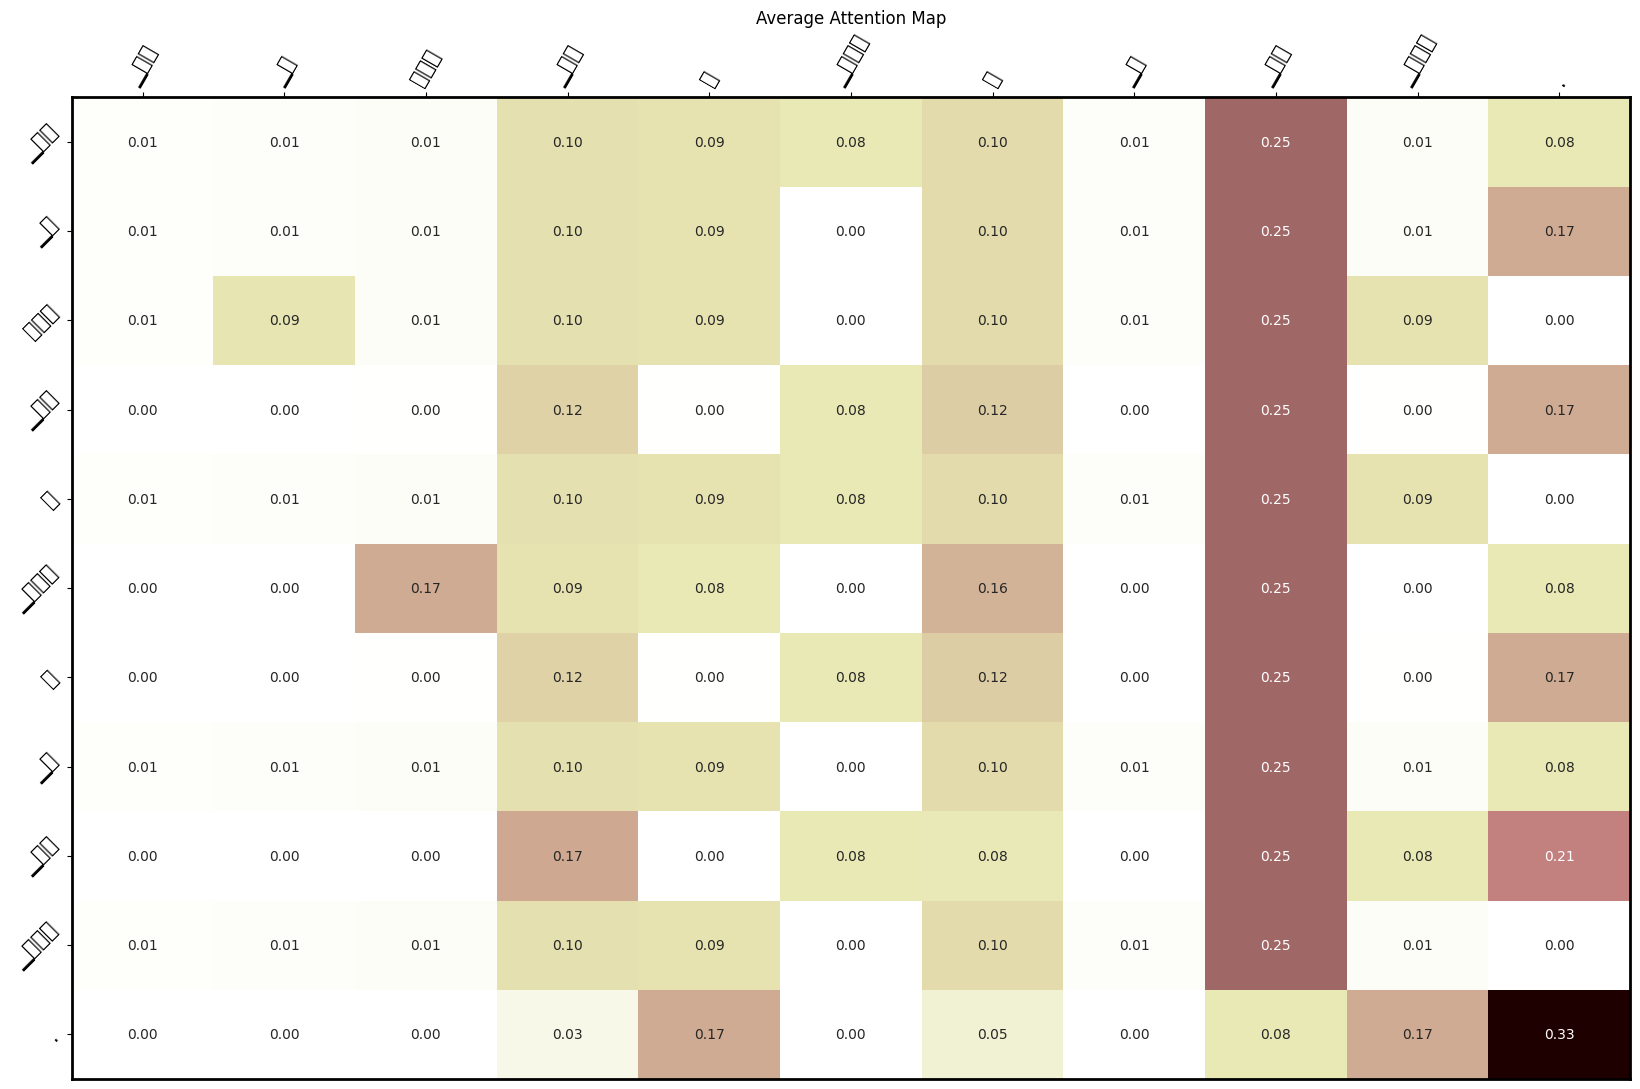

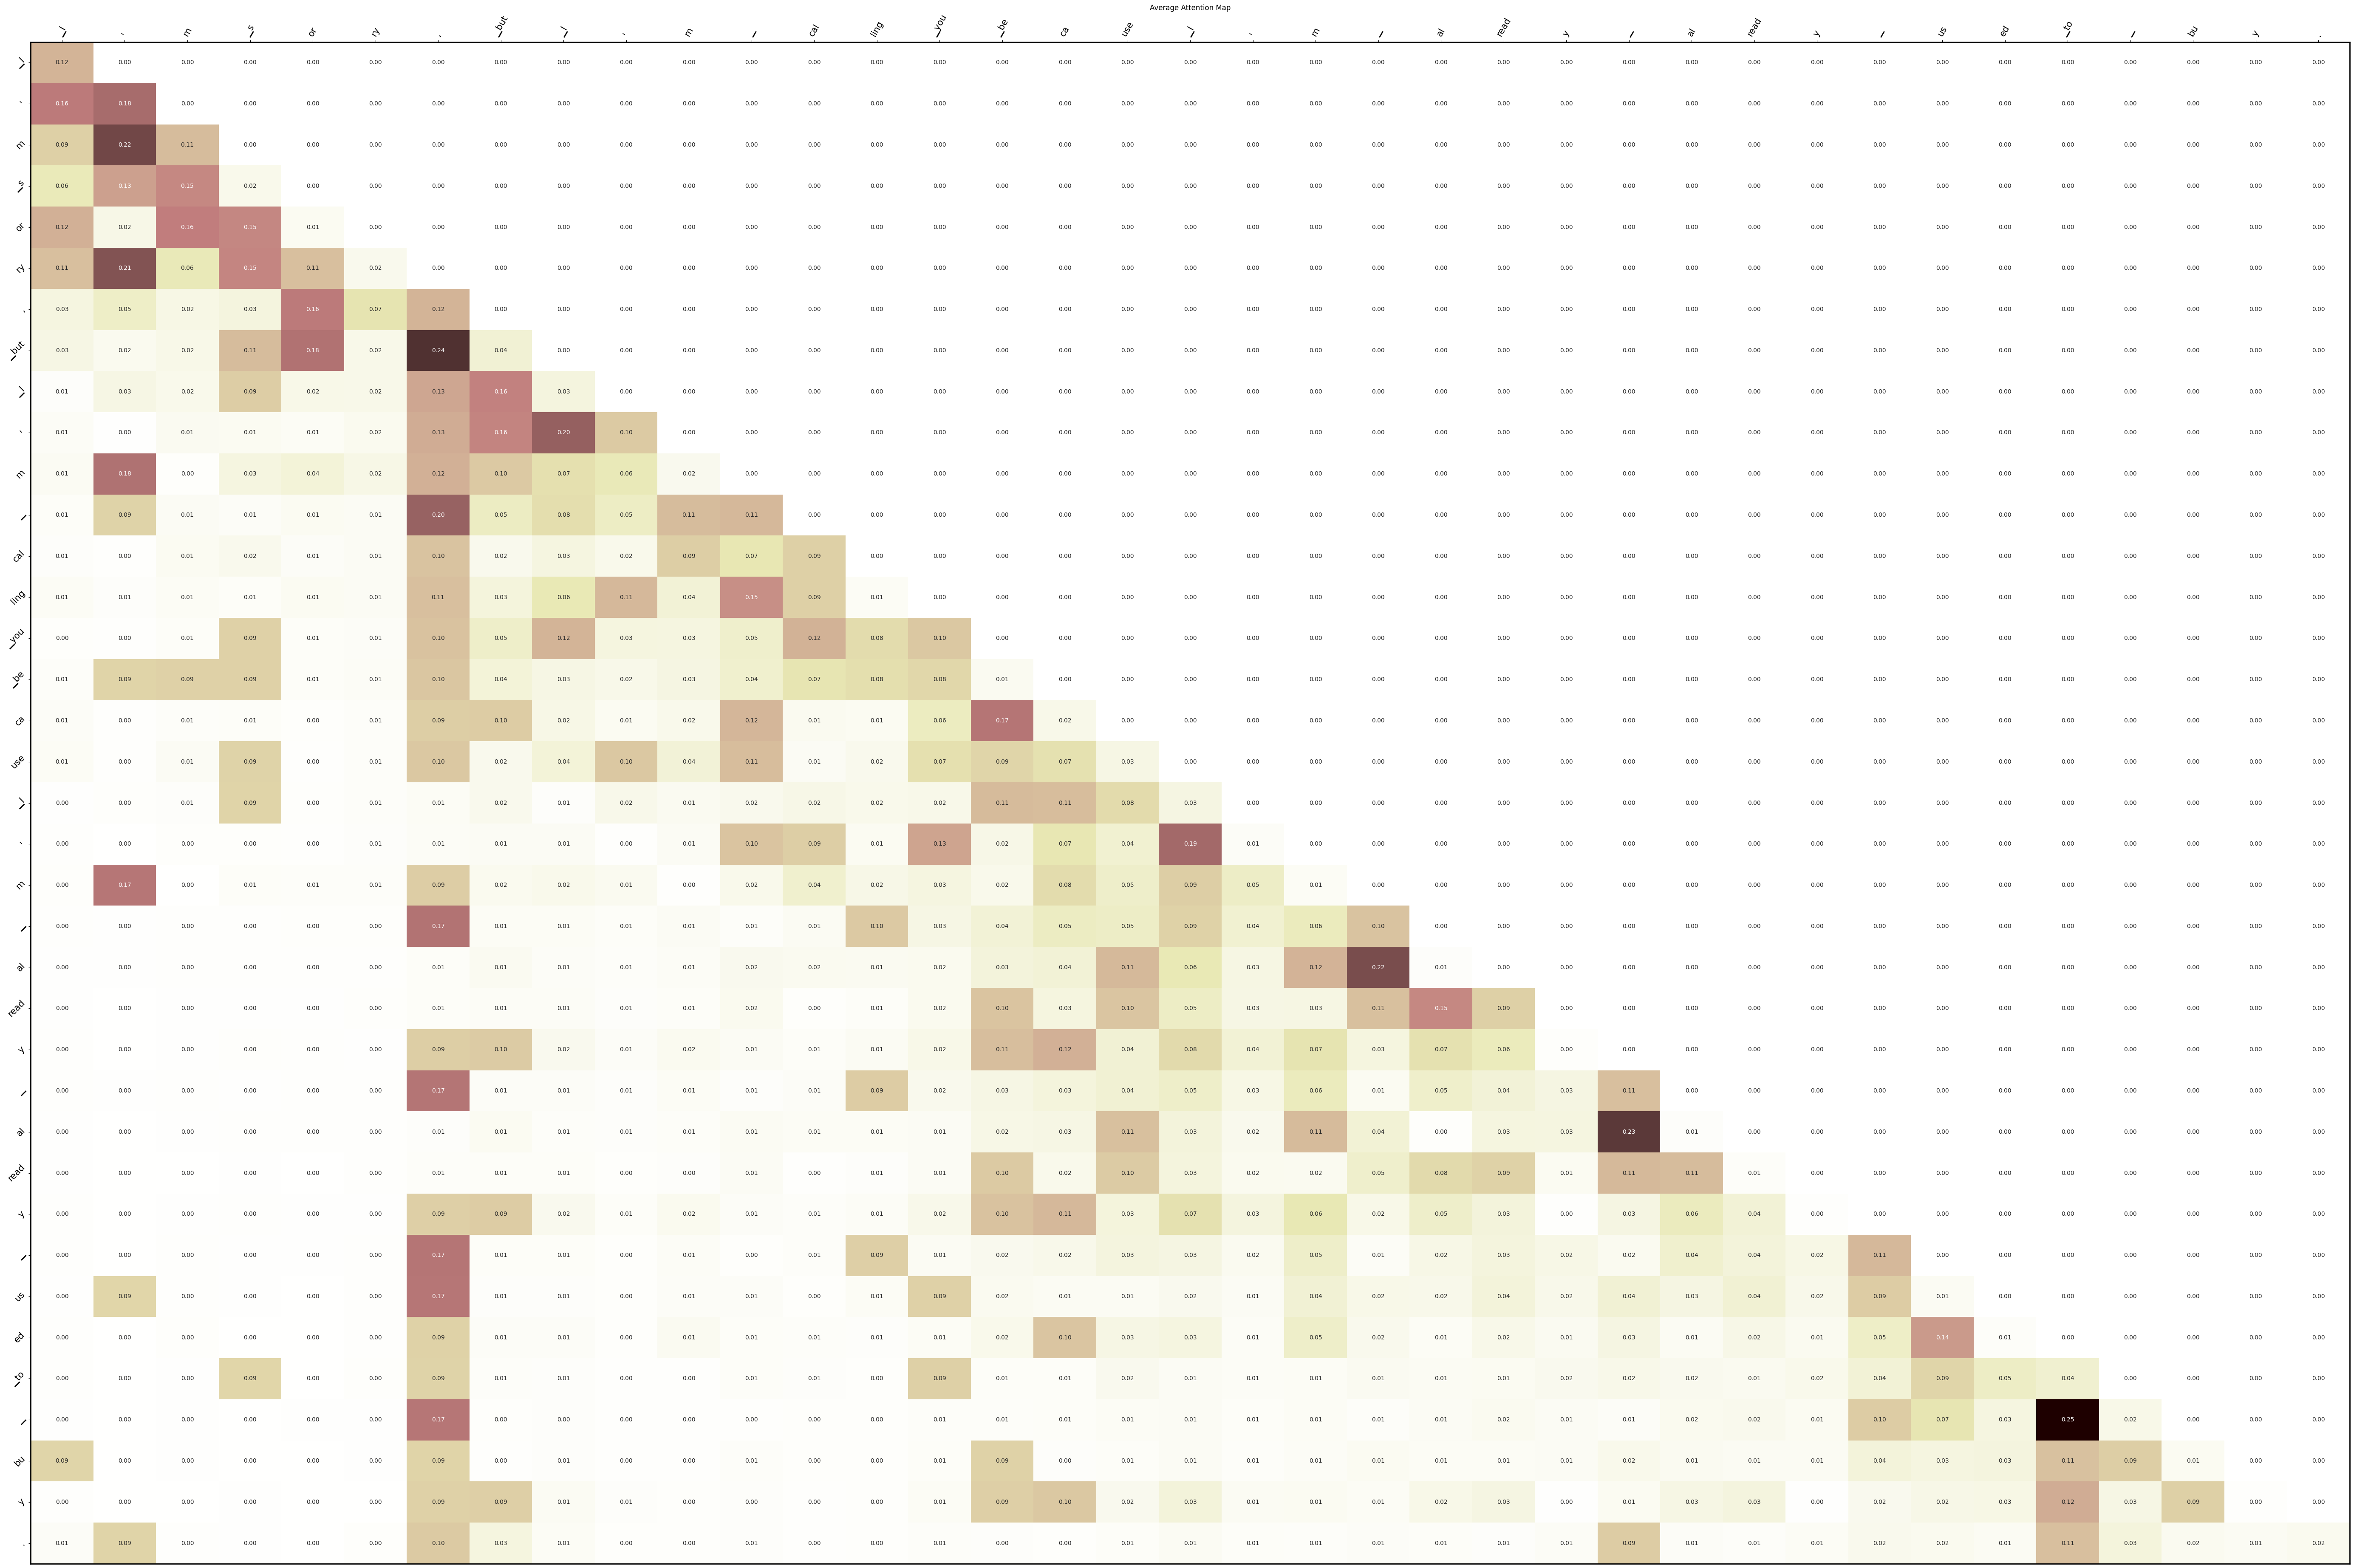

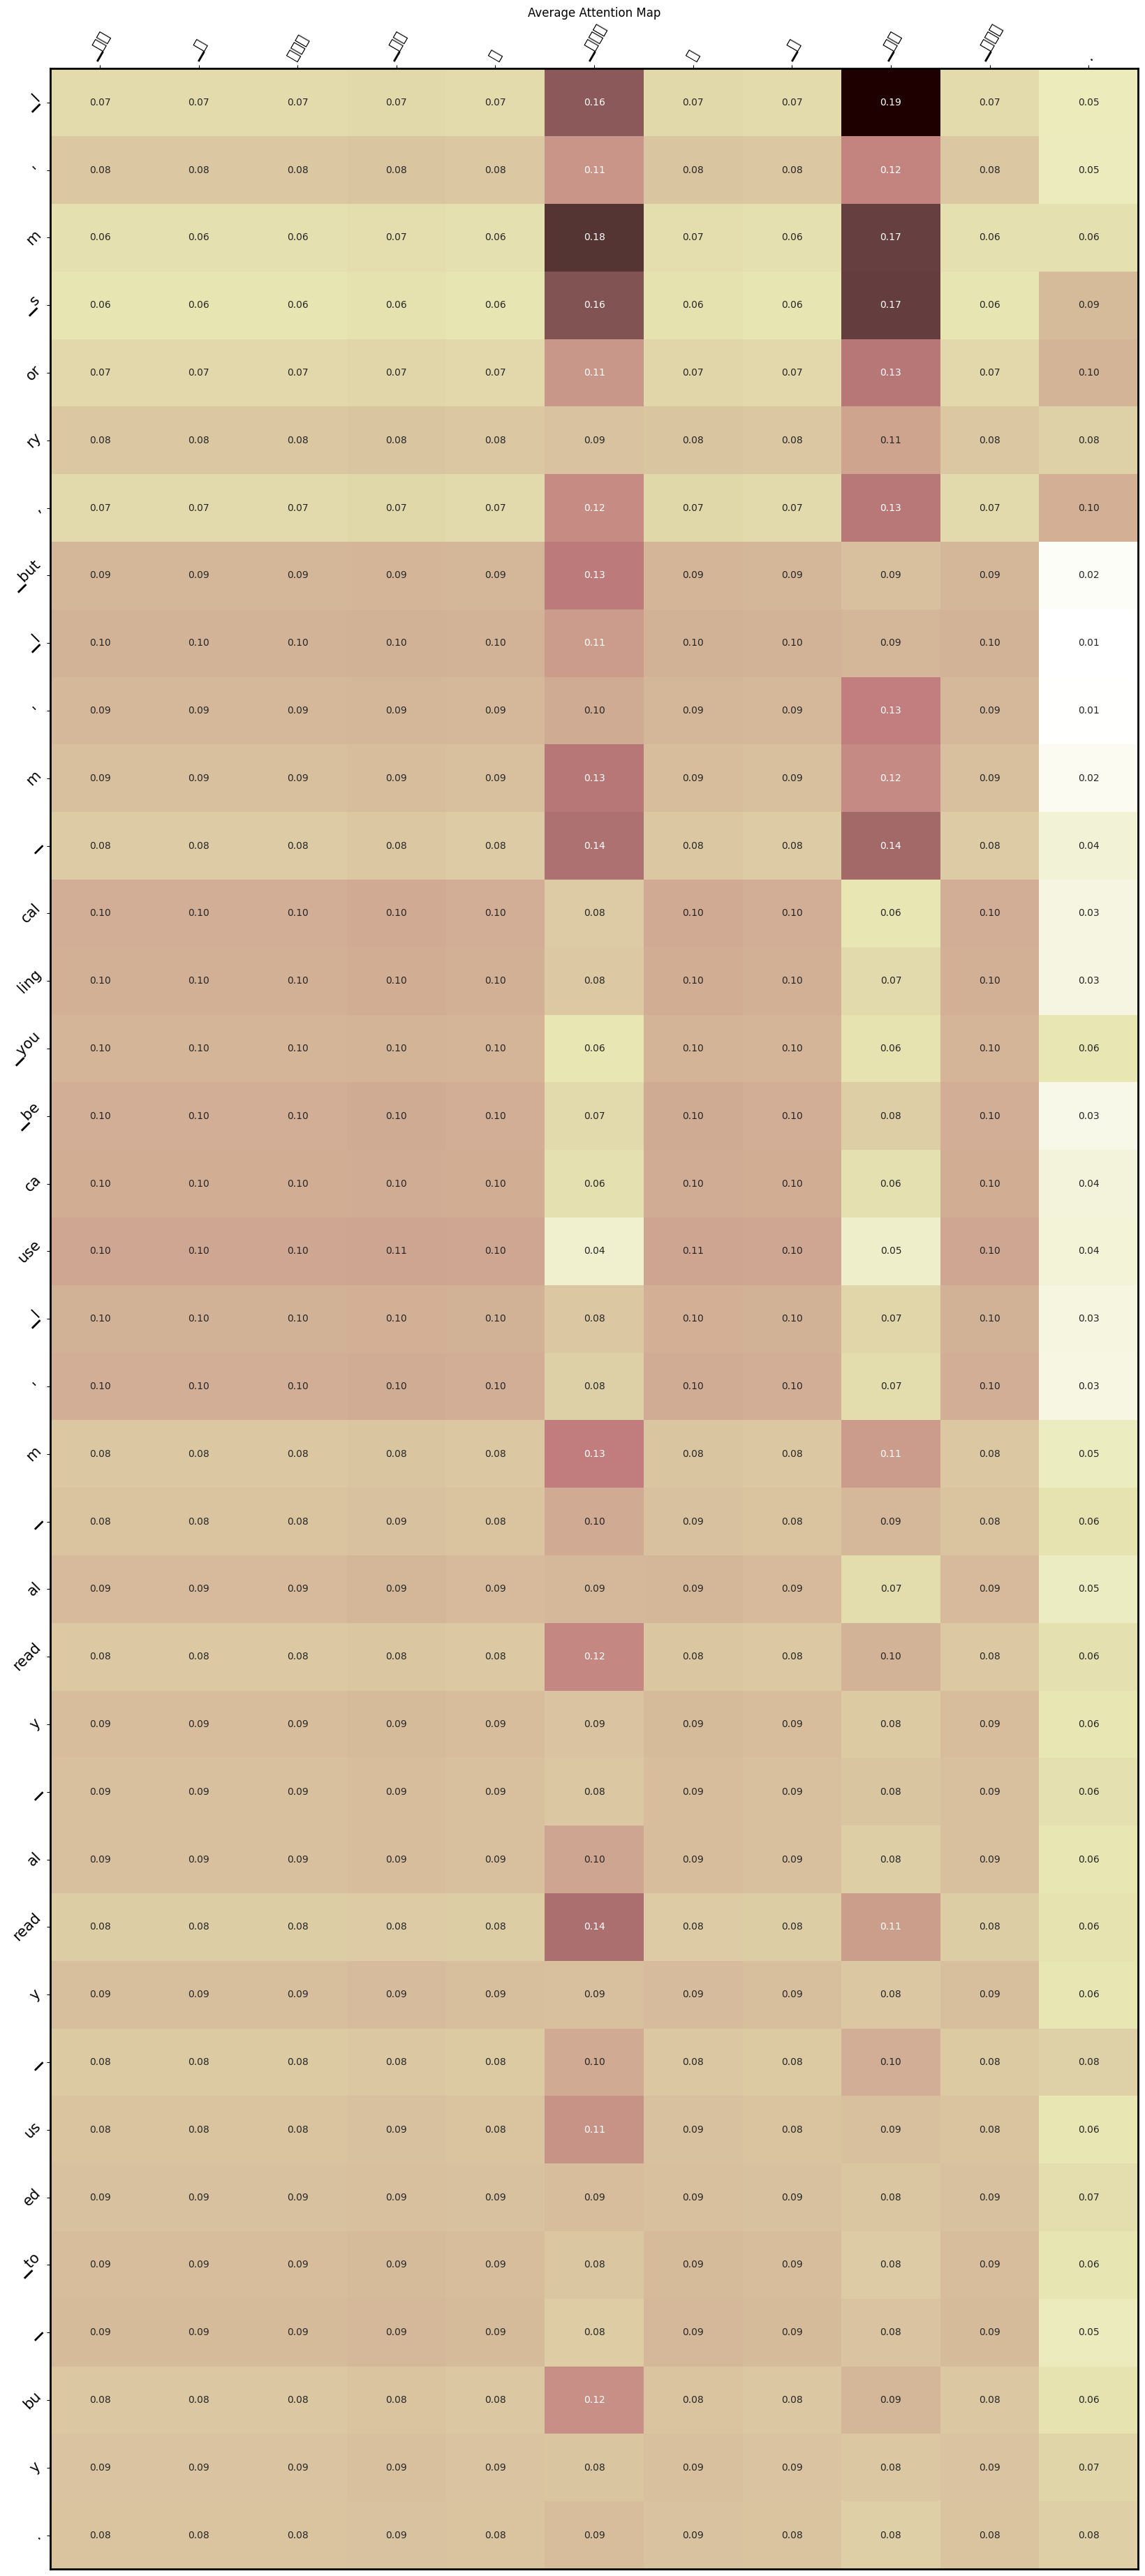

In [47]:
enc_input = tokenizer.tokenize(src_text+' </s>') # <eos> 붙여서 학습 시켰기 때문에 여기도 붙여줘야
dec_tokens = tokenizer.tokenize(translated_text)
dec_input = dec_tokens[:-1] # 디코더 입력으로 들어가는 문장(sos 는 있고 eos는 없고)
dec_output = dec_tokens[1:] # 디코더 출력으로 나간 문장

show_average_attention(atten_enc[:,:,:-1, :-1], enc_input[:-1], enc_input[:-1], style='pink_r') # 번역기 인코더의 경우
show_average_attention(atten_dec[:,:,1:,1:], dec_input[1:], dec_input[1:], style='pink_r')
show_average_attention(atten_enc_dec[:,:,:-1, :-1], dec_output[:-1], enc_input[:-1], style='pink_r')

### 4) Validation Score

In [ ]:
from torchtext.data.metrics import bleu_score

def calc_bleu_score(model, DS):
    trgs = []
    preds = []

    for i, (src_text, trg_text) in enumerate(DS):

        translated_text, _, _, _ = translation(load_model, src_text)

        trg = tokenizer.tokenize(trg_text)
        translated_tok = tokenizer.tokenize(translated_text)

        trgs += [[trg]]
        preds += [translated_tok]

        if (i + 1) % 100 == 0:
            print(f"[{i + 1}/{len(DS)}]")
            print(f"입력: {src_text}")
            print(f"정답: {trg_text}")
            print(f"AI의 번역: {translated_text[4:-4]}")

    bleu = bleu_score(preds, trgs)
    print()
    print(f'Total BLEU Score = {bleu*100:.2f}')

In [ ]:
calc_bleu_score(load_model, test_DS)